In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Model-specific imports
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# fetching the data
from ucimlrepo import fetch_ucirepo


In [3]:
# Load Dataset 
maternal_health_risk = fetch_ucirepo(id=863) 
  
X = maternal_health_risk.data.features 
y = maternal_health_risk.data.targets 

# combine features and targets for plotting
df = pd.merge(X, y, left_index=True, right_index=True)
df['RiskLevel'].value_counts()

low risk     406
mid risk     336
high risk    272
Name: RiskLevel, dtype: int64

| Variable Name | Role     | Type     | Demographic | Description                                                                             | Units  | Missing Values |
|---------------|----------|----------|-------------|-----------------------------------------------------------------------------------------|--------|----------------|
| Age           | Feature  | Integer  | Age         | Any ages in years when a woman is pregnant.                                              |        | no             |
| SystolicBP    | Feature  | Integer  |             | Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.    | mmHg   | no             |
| DiastolicBP   | Feature  | Integer  |             | Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.    | mmHg   | no             |
| BS            | Feature  | Integer  |             | Blood glucose levels in terms of a molar concentration.                                  | mmol/L | no             |
| BodyTemp      | Feature  | Integer  |             | Body temperature in degrees Fahrenheit (F).                                              | F      | no             |
| HeartRate     | Feature  | Integer  |             | A normal resting heart rate.                                                             | bpm    | no             |
| RiskLevel     | Target   | Categorical |         | Predicted Risk Intensity Level during pregnancy considering the previous attribute.       |        | no             |


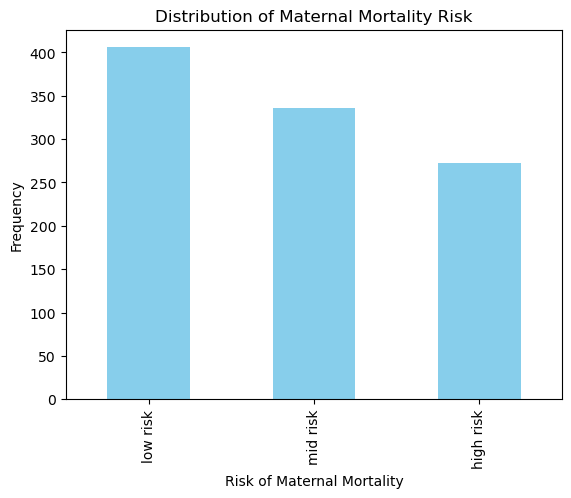

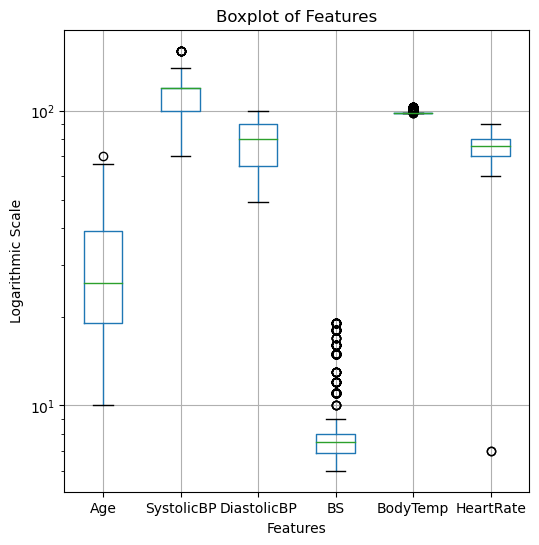

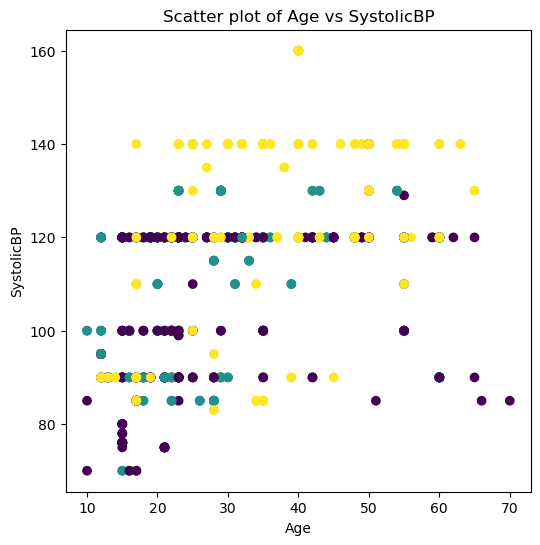

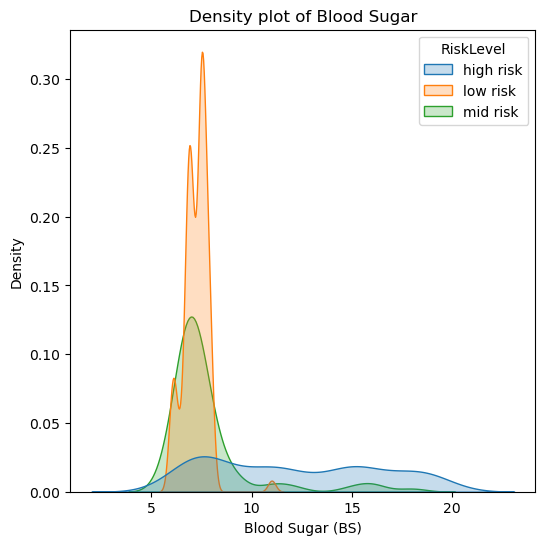

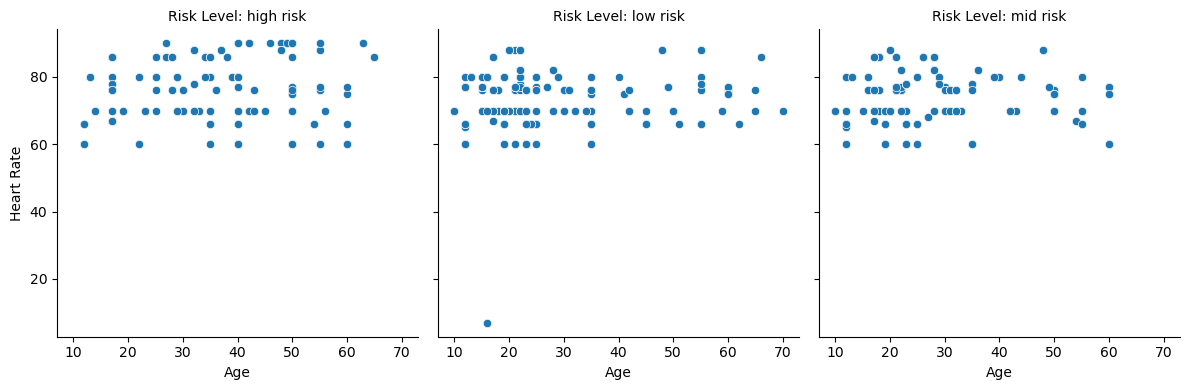

In [4]:
# Exploratory Data Analysis
# Plot the value counts of RiskLevel
ax = df['RiskLevel'].value_counts().plot(kind='bar', color='skyblue')
ax.set_xlabel('Risk of Maternal Mortality')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Maternal Mortality Risk')
plt.show()


# plot boxplot for the features
fig, ax = plt.subplots(figsize=(6, 6))
df.boxplot(column=['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'], ax=ax)
ax.set_yscale('log')
ax.set_title('Boxplot of Features')
ax.set_ylabel('Logarithmic Scale')
ax.set_xlabel('Features')
ax.set_xticklabels(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'])
plt.show()

# Convert categorical values to numeric
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
y_numeric = y['RiskLevel'].map(risk_mapping)


# Plot scatter plot of Age vs SystolicBP
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=X['Age'], y=X['SystolicBP'], c=y_numeric, cmap='viridis')
ax.set_xlabel('Age')
ax.set_ylabel('SystolicBP')
ax.set_title('Scatter plot of Age vs SystolicBP')
plt.show()

# Density plots of Blood Sugar (BS) for each RiskLevel
plt.figure(figsize=(6, 6))
sns.kdeplot(data=df, x='BS', hue='RiskLevel', fill=True)
plt.title('Density plot of Blood Sugar')
plt.xlabel('Blood Sugar (BS)')
plt.ylabel('Density')
plt.show()


# Risk Level Scatter Plot HeartRate vs Age
g = sns.FacetGrid(data=df, col='RiskLevel', height=4, aspect=1)
g.map(sns.scatterplot, "Age", "HeartRate")
g.set_axis_labels("Age","Heart Rate")
g.set_titles(col_template="Risk Level: {col_name}")
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Standardize the features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Accuracy: 0.6502463054187192
DiastolicBP    0.095304
Age            0.081940
HeartRate     -0.239415
BodyTemp      -0.578337
SystolicBP    -0.743324
BS            -1.191157
dtype: float64


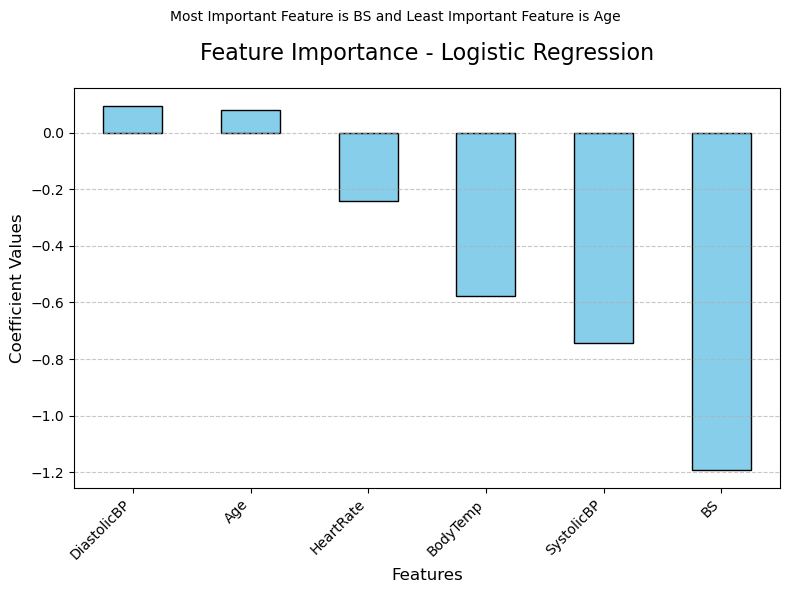

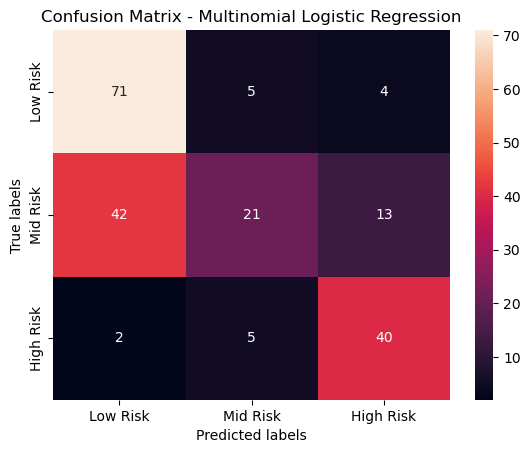

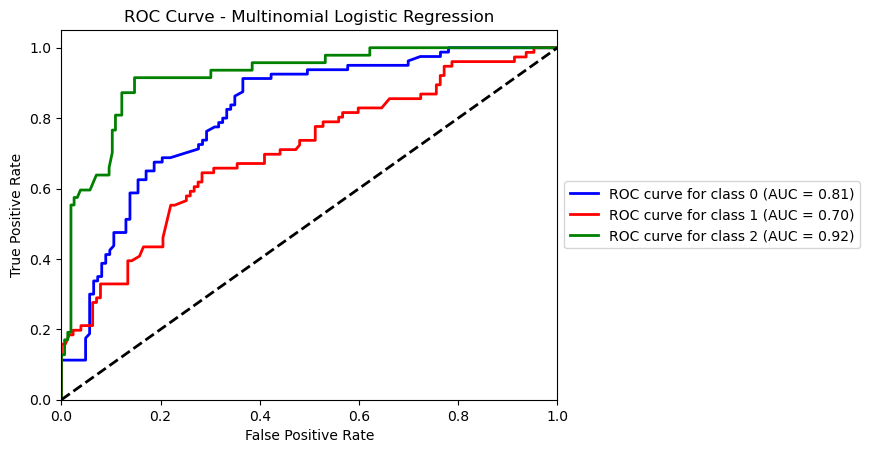

Macro-Averaged AUC: 0.812272978606904


In [6]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
log_reg = LogisticRegression(multi_class='multinomial', solver="lbfgs", max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Get predictions and probabilities
y_pred_logreg = log_reg.predict(X_test_scaled)
y_prob_logreg = log_reg.predict_proba(X_test_scaled)

# Calculate accuracy
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# Output predicted and actual values
# log_output = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_logreg})
# print(log_output)
print(f'Accuracy: {accuracy_logreg}')

logreg_feature_importance = pd.Series(log_reg.coef_[0], index=X.columns).sort_values(ascending=False)
print(logreg_feature_importance)

# Plot the feature importance
plt.figure(figsize=(8, 6))
ax = logreg_feature_importance.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Feature Importance - Logistic Regression', fontsize=16, pad=20)
plt.suptitle('Most Important Feature is BS and Least Important Feature is Age', y=0.98, fontsize=10)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Coefficient Values', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate Confusion Matrix and plot as a heatmap
cm = confusion_matrix(y_test, y_pred_logreg)

plt.figure()
sns.heatmap(cm,  annot=True, fmt='d', xticklabels=['Low Risk', 'Mid Risk', 'High Risk'], yticklabels=['Low Risk', 'Mid Risk', 'High Risk'])
plt.title('Confusion Matrix - Multinomial Logistic Regression')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Binarize the test labels for ROC curve calculation (One-vs-Rest method)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_logreg[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multinomial Logistic Regression')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Macro-average AUC across all classes
macro_auc = roc_auc_score(y_test_binarized, y_prob_logreg, average='macro')
print(f'Macro-Averaged AUC: {macro_auc}')

Feature Importance Scores:
Age            0.160320
SystolicBP     0.181785
DiastolicBP    0.118060
BS             0.367830
BodyTemp       0.067963
HeartRate      0.104043
dtype: float64


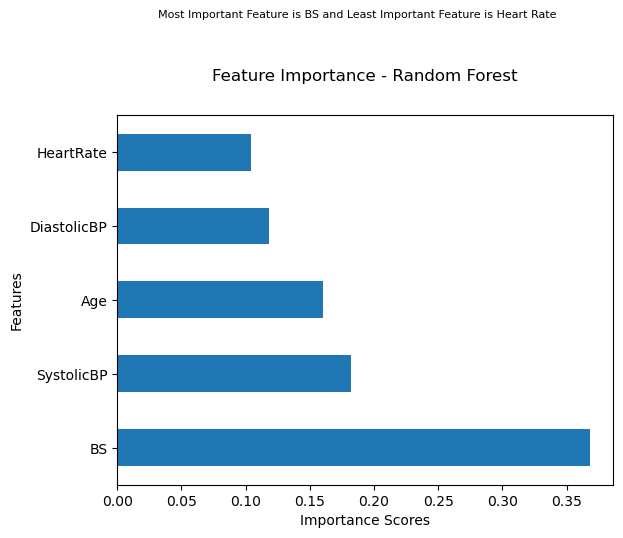

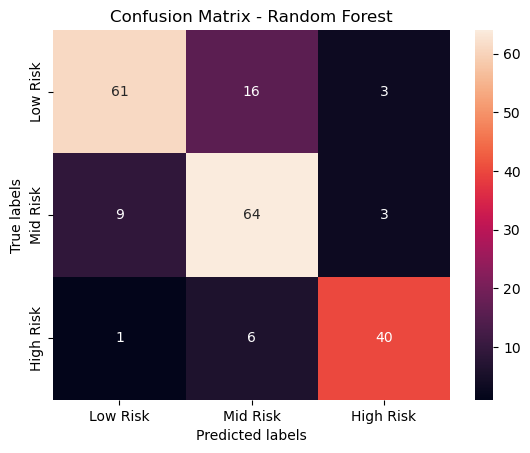

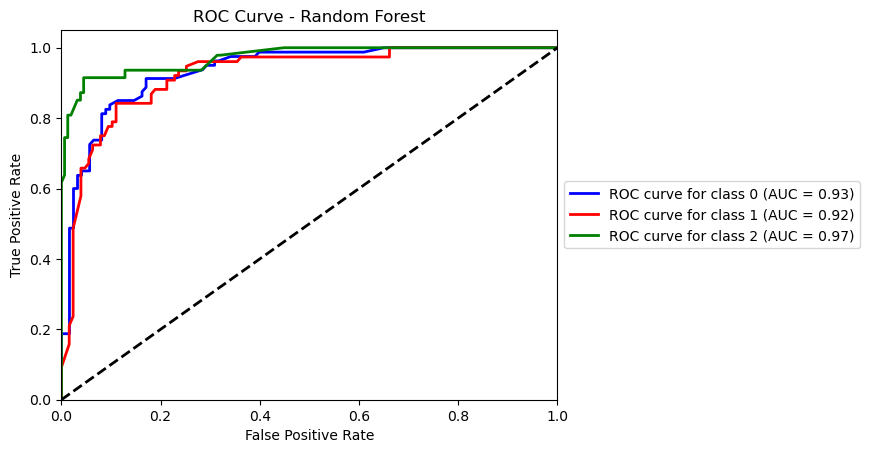

Macro-Averaged AUC for Random Forest: 0.9429315635988388


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)

y_pred_rfc = rf_clf.predict(X_test)

y_prob_rf = rf_clf.predict_proba(X_test)

# Binarize the labels for ROC calculation (same as before)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

rfc_feature_importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
print(f'Feature Importance Scores:\n{rfc_feature_importances}')

# Accuracy
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)

# Plot the feature importances
rfc_feature_importances.nlargest().plot(kind='barh')
plt.title('Feature Importance - Random Forest', pad=25)
plt.suptitle('Most Important Feature is BS and Least Important Feature is Heart Rate', y=1.1, fontsize=8)
plt.xlabel('Importance Scores')
plt.ylabel('Features')
plt.show()


# Compute and Plot confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred_rfc)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Low Risk', 'Mid Risk', 'High Risk'], yticklabels=['Low Risk', 'Mid Risk', 'High Risk'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


# Compute ROC curve and AUC for each class
fpr_rf, tpr_rf, roc_auc_rf = {}, {}, {}
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized[:, i], y_prob_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=2,
             label=f'ROC curve for class {i} (AUC = {roc_auc_rf[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Calculate Macro-Averaged AUC across all classes
macro_auc_rf = roc_auc_score(y_test_binarized, y_prob_rf, average='macro')
print(f'Macro-Averaged AUC for Random Forest: {macro_auc_rf}')

Accuracy of XGBoost: 0.8473
Accuracy of Optimized XGBoost: 0.8424
Best Parameters: {'max_depth': 5, 'n_estimators': 100}


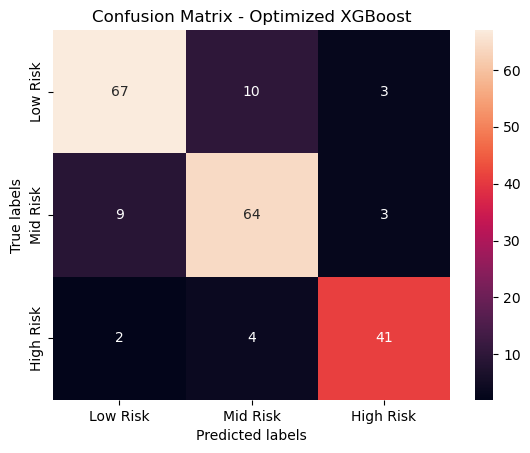

              precision    recall  f1-score   support

           0       0.87      0.84      0.85        80
           1       0.81      0.84      0.83        76
           2       0.85      0.85      0.85        47

    accuracy                           0.84       203
   macro avg       0.84      0.84      0.84       203
weighted avg       0.84      0.84      0.84       203



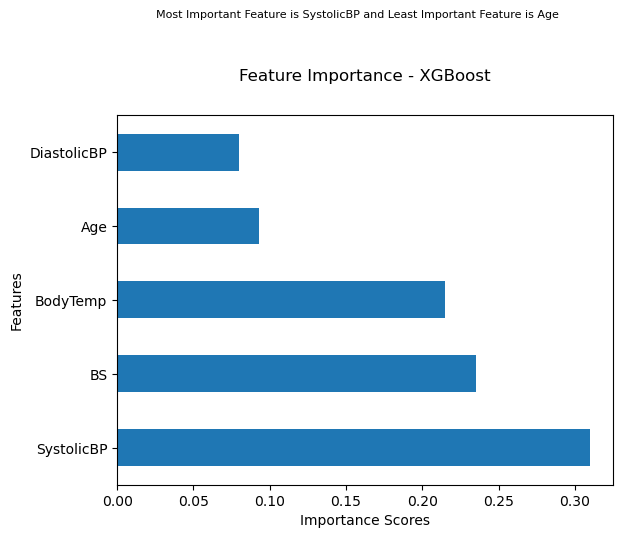

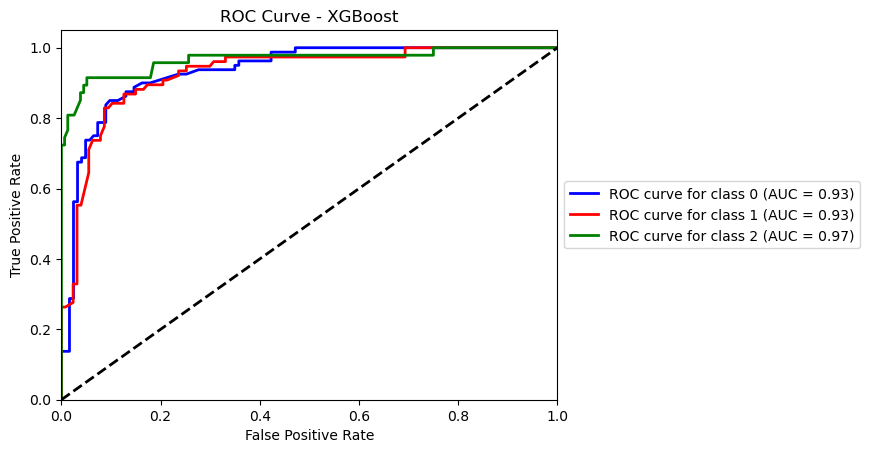

Macro-Averaged AUC: 0.942283215912238


In [13]:
import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300,).fit(X_train, y_train)
predictions_gbm = gbm.predict(X_test)

accuracy_xgb = accuracy_score(y_test, predictions_gbm)
print(f'Accuracy of XGBoost: {accuracy_xgb:0.4f}')

# Testing with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
optimized_GBM.fit(X_train, y_train)
predictions_optimized_GBM = optimized_GBM.predict(X_test)
accuracy_xgb_optimized = accuracy_score(y_test, predictions_optimized_GBM)
print(f'Accuracy of Optimized XGBoost: {accuracy_xgb_optimized:0.4f}')

print(f'Best Parameters: {optimized_GBM.best_params_}')


# Plot the confusion matrix
fig, ax = plt.subplots()
cm = confusion_matrix(y_test, predictions_gbm)
sns.heatmap(cm, ax=ax, annot=True, fmt='d', xticklabels=['Low Risk', 'Mid Risk', 'High Risk'], yticklabels=['Low Risk', 'Mid Risk', 'High Risk'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Optimized XGBoost')
plt.show()

print(classification_report(y_test, predictions_optimized_GBM))

# Plot the feature importances
gbm_feature_importances = pd.Series(gbm.feature_importances_, index=X.columns)
gbm_feature_importances.nlargest(5).plot(kind='barh')
plt.title('Feature Importance - XGBoost', pad=25)
plt.suptitle('Most Important Feature is SystolicBP and Least Important Feature is DiastolicBP', y=1.1, fontsize=8)
plt.xlabel('Importance Scores')
plt.ylabel('Features')
plt.show()

# Plot the ROC curve
y_prob_xgb = gbm.predict_proba(X_test)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Adjust based on the number of classes
n_classes = y_test_binarized.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Macro-average AUC across all classes
macro_auc_xgb = roc_auc_score(y_test_binarized, y_prob_xgb, average='macro')
print(f'Macro-Averaged AUC: {macro_auc_xgb}')

In [48]:
from sklearn.metrics import classification_report

#
# Get classification reports for all models
report_xgb = classification_report(y_test, predictions_optimized_GBM, output_dict=True)
report_rfc = classification_report(y_test, y_pred_rfc, output_dict=True)
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True)

# Extract accuracy, precision, and F1-score for all models
metrics = {
    'Model': ['XGBoost', 'RandomForest', 'Logistic Regression'],
    'Accuracy': [accuracy_xgb, accuracy_rfc, accuracy_logreg],
    'Precision': [report_xgb['weighted avg']['precision'], report_rfc['weighted avg']['precision'], report_logreg['weighted avg']['precision']],
    'F1-Score': [report_xgb['weighted avg']['f1-score'], report_rfc['weighted avg']['f1-score'], report_logreg['weighted avg']['f1-score']]
}

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                 Model  Accuracy  Precision  F1-Score
0              XGBoost  0.847291   0.843251  0.842569
1         RandomForest  0.812808   0.818523  0.813376
2  Logistic Regression  0.650246   0.659397  0.612030
